<a href="https://colab.research.google.com/github/shruttay/Fraud_Detection_System/blob/main/marathi_sentiment_muril_bilstm_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [10]:
# Install required packages
%pip install -qq transformers
%pip install -q -U watermark

# Imports
import os
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import torch
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import AdamW  # Correct usage
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

# Seed and device setup
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [11]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.12
IPython version      : 7.34.0

numpy       : 2.0.2
pandas      : 2.2.2
torch       : 2.6.0+cu124
transformers: 4.51.1



# Dataset Loading

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
df_train = pd.read_pickle('/content/gdrive/MyDrive/marathi/marathi_train.pkl')
df_test = pd.read_pickle('/content/gdrive/MyDrive/marathi/marathi_test.pkl')
df_valid = pd.read_pickle('/content/gdrive/MyDrive/marathi/marathi_valid.pkl')

# Data analysis

In [ ]:
sns.countplot(df_test.label)
plt.xlabel('Sentiment')

In [ ]:
sns.countplot(df_valid.label)
plt.xlabel('Sentiment')

In [ ]:
pd.set_option("display.max_colwidth", -1)
df_train.head(10)

# Preprocessing with transformers

In [20]:
PRE_TRAINED_MODEL_NAME = 'google/muril-base-cased'

In [21]:
muril_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

In [22]:
sample_txt = 'मेरी आणि सामंथा बस स्थानकावर लवकर पोहोचल्या पण दुपारपर्यंत बसची वाट पाहत बसले'

In [23]:


tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')



 Sentence: मेरी आणि सामंथा बस स्थानकावर लवकर पोहोचल्या पण दुपारपर्यंत बसची वाट पाहत बसले
   Tokens: ['मेरी', 'आणि', 'साम', '##ं', '##था', 'बस', 'स्थानकावर', 'लवकर', 'पो', '##हो', '##चल', '##्या', 'पण', 'दु', '##पार', '##पर्यंत', 'बसची', 'वाट', 'पाहत', 'बसले']
Token IDs: [5572, 1196, 73018, 1199, 15766, 4145, 109874, 48212, 58233, 33630, 38817, 2904, 2963, 20761, 39423, 8191, 134666, 19497, 87623, 96800]


In [24]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 105
[CLS] 104
[PAD] 0
[UNK] 100


In [25]:


encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32, # Max no. of tokens
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [26]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

32


tensor([[   104,   5572,   1196,  73018,   1199,  15766,   4145, 109874,  48212,
          58233,  33630,  38817,   2904,   2963,  20761,  39423,   8191, 134666,
          19497,  87623,  96800,    105,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0]])

In [27]:
print(len(encoding['token_type_ids'][0]))
encoding['token_type_ids']

32


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [28]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [29]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'मेरी',
 'आणि',
 'साम',
 '##ं',
 '##था',
 'बस',
 'स्थानकावर',
 'लवकर',
 'पो',
 '##हो',
 '##चल',
 '##्या',
 'पण',
 'दु',
 '##पार',
 '##पर्यंत',
 'बसची',
 'वाट',
 'पाहत',
 'बसले',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [30]:
token_lens = []
for txt in tqdm(df_train.tuned_tweet):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

100%|██████████| 12109/12109 [00:02<00:00, 5047.30it/s]


<ipython-input-31-f8256fc61210>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


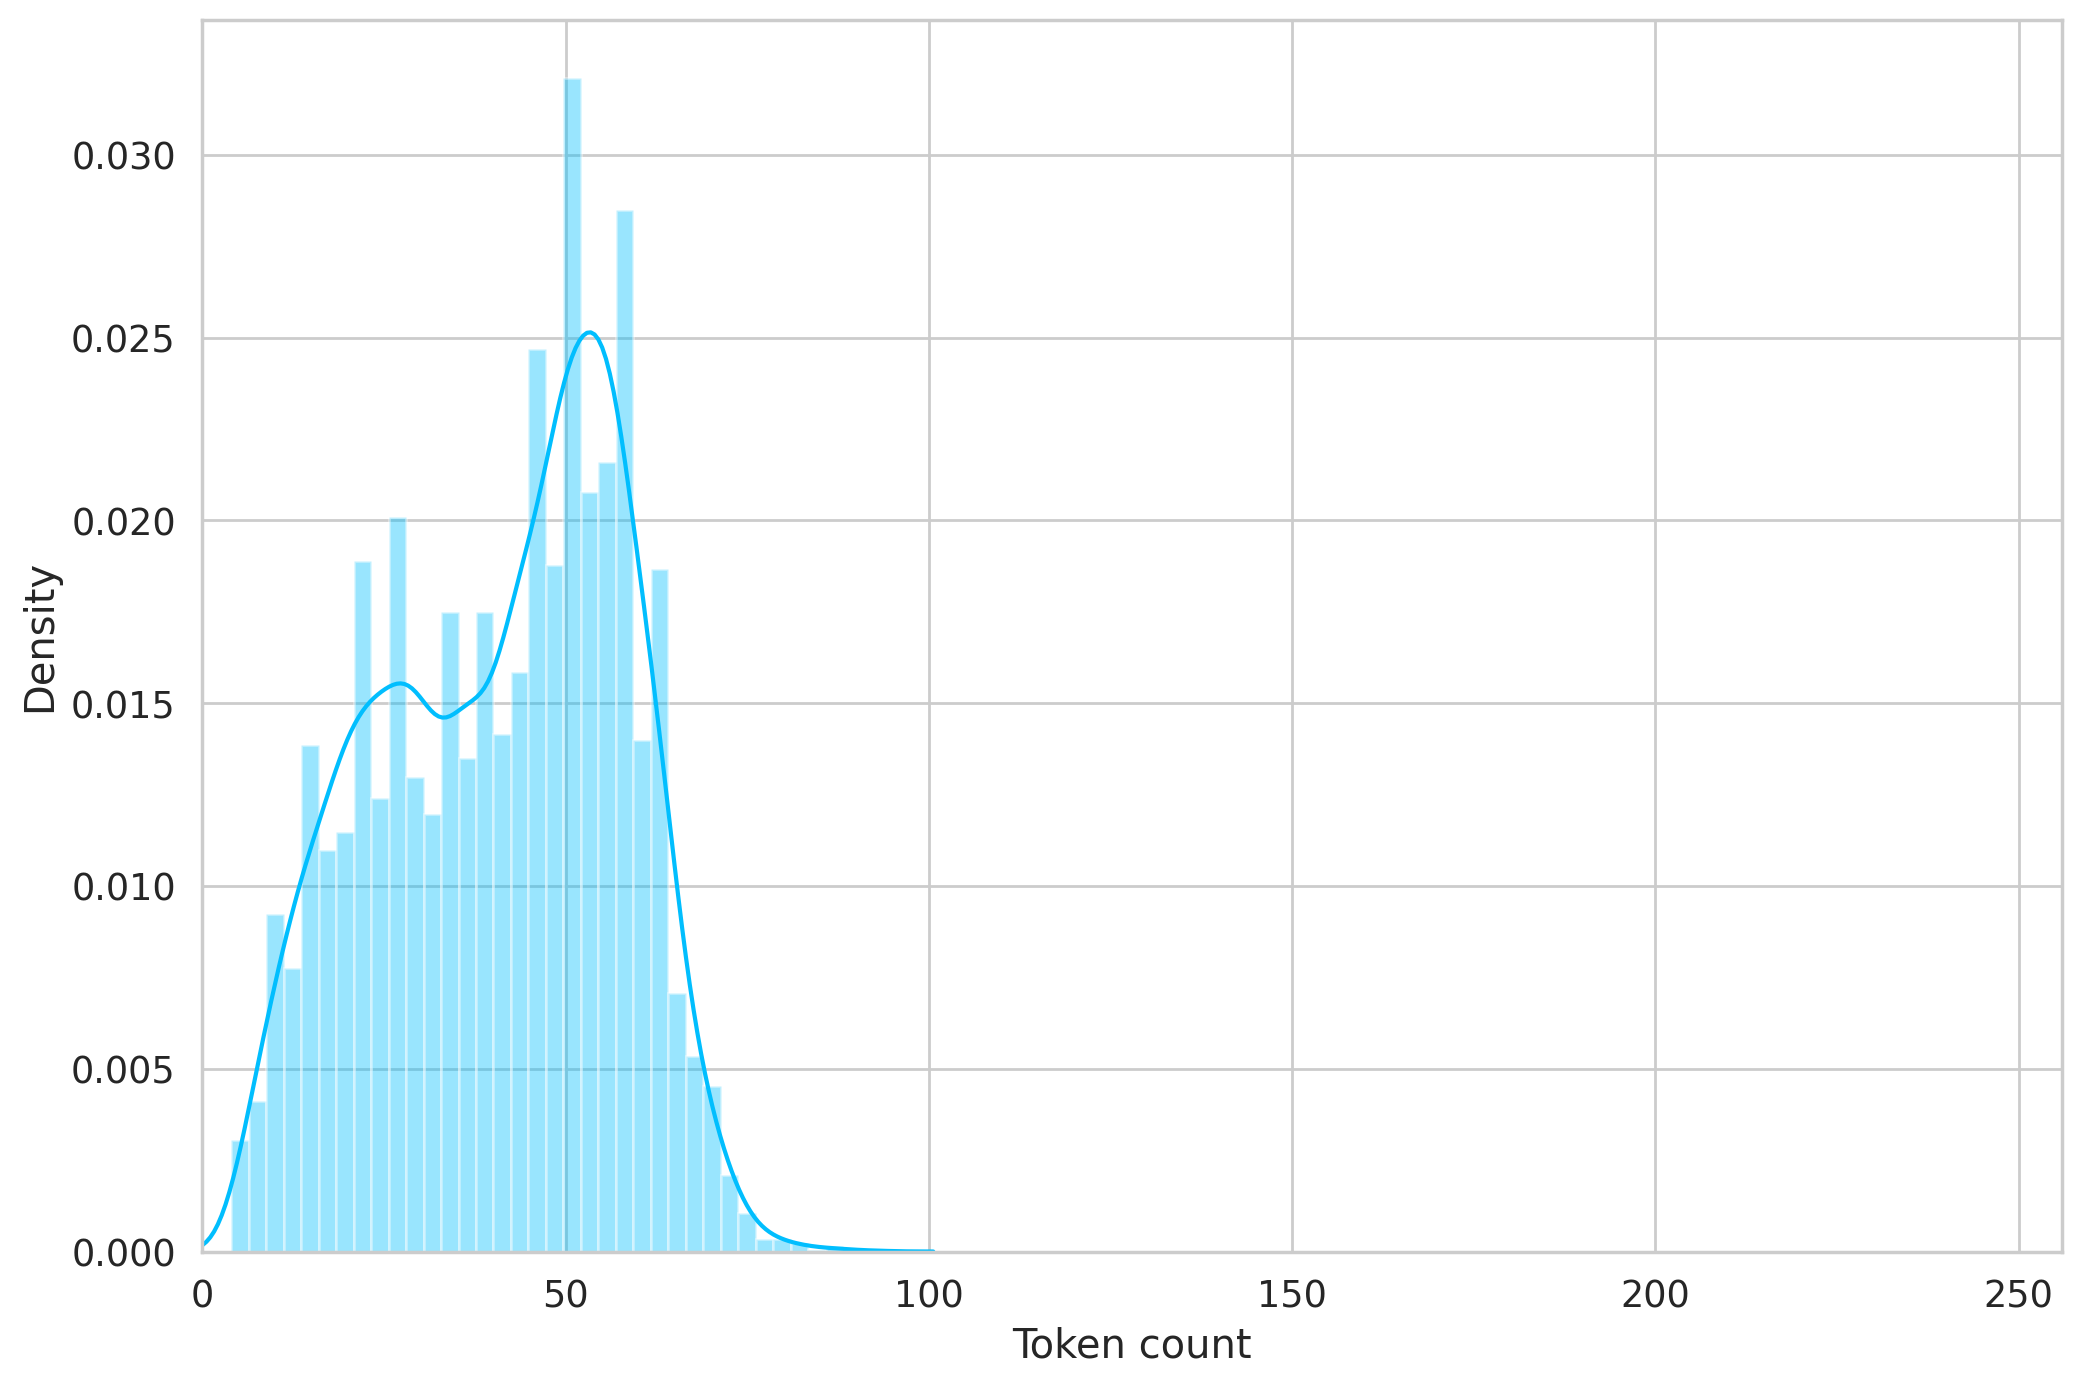

In [31]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.show()

In [32]:
MAX_LEN = 160

In [33]:
class GPReviewDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      return_attention_mask=True,
      padding= 'max_length',
      # pad_to_max_length = True,
      return_tensors='pt',
    )

    return {
      'tweet_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'type_ids': encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [34]:
df_train.shape, df_valid.shape, df_test.shape

((12109, 3), (1499, 3), (2250, 3))

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.tuned_tweet.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [36]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [37]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Classification

In [39]:
print(encoding['attention_mask'] , encoding['token_type_ids'])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]) tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [40]:
x = muril_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  token_type_ids=encoding['token_type_ids']
)

In [41]:
print(x['last_hidden_state'].shape, x['pooler_output'].shape)

torch.Size([1, 32, 768]) torch.Size([1, 768])


In [42]:
muril_model.config.hidden_size

768

In [43]:

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, base):
    super(SentimentClassifier, self).__init__()
    self.muril = base
    self.drop1 = nn.Dropout(p=0.3)
    self.lstm = nn.LSTM(base.config.hidden_size, 150,bidirectional=True,dropout=0.2)
    self.out1 = nn.Linear(300,64)
    self.relu = nn.ReLU()
    self.drop2 = nn.Dropout(p=0.1)
    self.out = nn.Linear(64, n_classes)

  def forward(self, input_ids, attention_mask, token_type_ids):
    x = self.muril(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    pooled_output = x['pooler_output']
    output = self.drop1(pooled_output)
    output = output.view(len(output), 1, -1)
    output, _ = self.lstm(output)
    output = output.view(len(output), output.shape[-1])
    output =self.relu(self.out1(output))
    output = self.drop2(output)
    return self.out(output)

In [44]:

class_names = ['-1','0', '1']
model = SentimentClassifier(len(class_names), muril_model)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [45]:
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [46]:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq_length

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16, 160])


In [47]:
data

{'tweet_text': ['ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे वृत्त दु:खद आहे चार दशकं त्यांनी आपल्या परखड लेखणीने पत्रकारितेत अमूल्य योगदान दिले दीक्षित यांच्या मार्गदर्शनाखाली पत्रकारांची पिढी घडली अनंत दीक्षित यांना भावपूर्ण श्रद्धांजली आम्ही त्यांच्या परिवाराच्या दु:खात सहभागी आहोत',
  'सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोलिसांनी प्रा आनंद तेलतुंबडेंना अटक केली मात्र न्यायालयाने त्यांची अटक बेकायदेशीर ठरवून सरकारला जोरदार चपराक लगावली आहे कायदा हातात घेणा-या पोलीस अधिका-यांवर तात्काळ कारवाई केली पाहिजे AnandTeltumbde',
  'उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिकांचा अवमान व विश्वासघात केला आहे फसवणूक झालेल्या शिवसैनिकांबद्दल मला सहानुभूती असून स्वार्थासाठी उद्धव ठाकरे भाजपसोबत गेले तरी मोदींचे सरकार घालवण्यातच महाराष्ट्राचे हित आहे हे जाणणारे शिवसैनिक मोदींच्या विरोधात काँग्रेसला मतदान करतील',
  'आपला समाज खूप मोठा आहे त्यात अनेक घटक अंतर्भूत आहेत यातील दिव्यांग हा एक घटक, जो शारीरिकदृष्ट्या कमकुवत आहे, त्याच्याकडे समाजाचे दुर्लक्ष होतेय त्यामुळे सरकारने अशा व्यक्तींसाठी 

In [48]:
input_ids

tensor([[   104,  17857,   8096,  ...,      0,      0,      0],
        [   104,   8385, 120210,  ...,      0,      0,      0],
        [   104,  80460,  31017,  ...,      0,      0,      0],
        ...,
        [   104,   4842,   3274,  ...,      0,      0,      0],
        [   104, 104023,   1373,  ...,      0,      0,      0],
        [   104,    100,   1680,  ...,      0,      0,      0]],
       device='cuda:0')

In [49]:
model(input_ids, attention_mask, token_type_ids)

tensor([[-0.0352, -0.0057,  0.0456],
        [-0.0380,  0.0023,  0.0569],
        [-0.0561,  0.0015,  0.0592],
        [-0.0432, -0.0092,  0.0477],
        [-0.0489, -0.0044,  0.0497],
        [-0.0542, -0.0045,  0.0585],
        [-0.0432, -0.0122,  0.0543],
        [-0.0395, -0.0168,  0.0461],
        [-0.0528, -0.0052,  0.0360],
        [-0.0515, -0.0210,  0.0466],
        [-0.0542, -0.0099,  0.0505],
        [-0.0482, -0.0069,  0.0567],
        [-0.0393, -0.0161,  0.0546],
        [-0.0471, -0.0109,  0.0481],
        [-0.0474, -0.0122,  0.0525],
        [-0.0523, -0.0042,  0.0509]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [50]:
F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)

tensor([[0.3200, 0.3287, 0.3513],
        [0.3180, 0.3312, 0.3508],
        [0.3187, 0.3298, 0.3515],
        [0.3191, 0.3267, 0.3541],
        [0.3208, 0.3288, 0.3504],
        [0.3159, 0.3294, 0.3547],
        [0.3174, 0.3321, 0.3504],
        [0.3184, 0.3297, 0.3519],
        [0.3184, 0.3294, 0.3522],
        [0.3176, 0.3317, 0.3507],
        [0.3198, 0.3314, 0.3488],
        [0.3170, 0.3322, 0.3508],
        [0.3166, 0.3335, 0.3499],
        [0.3181, 0.3299, 0.3519],
        [0.3185, 0.3292, 0.3523],
        [0.3200, 0.3313, 0.3487]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [58]:
from transformers import get_linear_schedule_with_warmup
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=1e-5,)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [59]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d['type_ids'].to(device)
    targets = d["targets"].to(device)
    targets+=1

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [60]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)
      targets+=1

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids

      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


In [1]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\n--> Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_valid)
  )

  print(f'--> Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'muril_bilstm_model_state.bin')
    best_accuracy = val_acc


NameError: name 'defaultdict' is not defined

# Results

In [ ]:
for i in range(len(history["train_acc"])):
  history["train_acc"][i]=history["train_acc"][i].cpu()

In [ ]:
for i in range(len(history["val_acc"])):
  history["val_acc"][i]=history["val_acc"][i].cpu()

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([.8, 1]);

# Evaluation

In [ ]:
model2 = SentimentClassifier(len(class_names), muril_model)
model2.load_state_dict(torch.load('muril_bilstm_model_state.bin'))
model2.eval()

In [ ]:
model2 = model2.to(device)

In [ ]:
test_acc, _ = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids = token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [ ]:

y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
y_pred-=1

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
y_test[50:60]

In [ ]:
idx = 50

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print('\n\n',tweet_text, '\n\n')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
y_test[14], y_tweet_texts[14]

# Custom Prediction

In [ ]:
# strip -> punctuations  -> @ mentions delete -> url delete ->  remove # from #-tokens -> stop words delete (no delete )  -> rare words no delete)
def preprocess(line):

  line = line.strip()
  line = re.sub(r'\S*\.com\S*'," ",line)
  line = re.sub(r'\S*\.in\S*'," ",line)
  line = re.sub(r'\S*\.net\S*'," ",line)
  line = re.sub(r'\S*\.me\S*'," ",line)
  line = re.sub(r'\s+:\s+'," ",line)
  line = re.sub(r'\s+-\s+'," ",line)


  line = re.sub(r'/https?\/\/(.*\.(in))\//'," ",line)
  line = re.split(r'\s+|[!$%&()*+./;<=>?\^`{|}~\'\"]\s*', line)
  line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']

  if len(line) > 1:
    tokens = []
    for i in range(len(line)):
      if line[i][0] == '#':
        tokens.append(line[i][1:])
      elif line[i][0] == '@' or line[i][0] in string.punctuation :
        continue
      else:
        tokens.append(line[i])
    return tokens


In [ ]:
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "प्रौढ प्रताप पुरंदर, क्षत्रिय कुलावतंस, सिंहासनाधीश्वर, महाराजाधिराज महाराज श्रीमंत श्री छत्रपती शिवाजी महाराज की जय"
tweet_text = "मनाचे वेधना किती सोसावे सामान्य माणसाने"
tweet_text = "माननीय महोदय संजय विचारे यांच्या अपघाताची बातमी आज कळाली. खूप वाईट वाटले."
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "गढ आला पण माझा सिंह गेला"
tweet_text = "मैदानात हजारो कंडोम पाकीटं कुणी फेकली?; खुलासा होताच अधिकाऱ्यांनी डोक्यावर हात मारला"
tweet_text = "महाशिवरात्रीच्या सर्वांना हार्दिक हार्दिक शुभेच्छा"
tweet_text= "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "हिंदू धर्मात मुलांना लहानपणापासून आपला धर्मग्रंथ गीता शिकवला जात नाही हे सत्य आहे."
tweet_text = "प्रा. यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय."
tweet_text = preprocess(tweet_text)
tweet_text = " ".join(tweet_text)

In [ ]:

encoded_tweet = tokenizer.encode_plus(
  tweet_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


In [ ]:
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)

output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

print(f'Tweet text: {tweet_text}')
print(f'Sarcasm  : {class_names[prediction]}')